# Q3. Named Entity Recognition

## Q3.1 Features

We'll first import the libreries needed, and get the data.

In [36]:
%matplotlib inline

from itertools import chain
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import hashlib
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

### Feature extraction

Here are our methods for extracting the word-features and lables from the senteses. 

In [3]:

def word2featuresWithPadding(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        #'bias',
        'word.lower^' + word.lower(),
        'word[-3:]^' + word[-3:],
        'word[-2:]^' + word[-2:],
        'word.isupper^%s' % word.isupper(),
        'word.istitle^%s' % word.istitle(),
        'word.isdigit^%s' % word.isdigit(),
        'postag^' + postag,
        'postag[:2]^' + postag[:2],
    ]
    word1 = None
    postag1 = None
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
    else: # padding
        word1 = '&&'
        postag1 = 'BOS'
    features.extend([
        '-1:word.lower^' + word1.lower(),
        '-1:word.istitle^%s' % word1.istitle(),
        '-1:word.isupper^%s' % word1.isupper(),
        '-1:postag^' + postag1,
        '-1:postag[:2]^' + postag1[:2],
    ])
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
    else: # padding
        word1 = '@@'
        postag1 = 'EOS'
    features.extend([
        '+1:word.lower^' + word1.lower(),
        '+1:word.istitle^%s' % word1.istitle(),
        '+1:word.isupper^%s' % word1.isupper(),
        '+1:postag^' + postag1,
        '+1:postag[:2]^' + postag1[:2],
    ])
    return features


def sent2featuresWithPadding(sent):
    return [word2featuresWithPadding(sent, i) for i in range(len(sent))]

def sent2labelsWithPadding(sent):
    return [label for token, postag, label in sent]

def sent2tokensWithPadding(sent):
    return [token for token, postag, label in sent]    


Get the features and the labels.

In [45]:
X_train = [sent2featuresWithPadding(s) for s in train_sents]
y_train = [sent2labelsWithPadding(s) for s in train_sents]

X_test = [sent2featuresWithPadding(s) for s in test_sents]
y_test = [sent2labelsWithPadding(s) for s in test_sents]

Create a dictionary of the features for each word.<br>

In [5]:
final_x_train = []
final_y_train = []
for sentence_ind in range(int(len(X_train))):
    #print(sentence_ind)
    for word_ind in range(len(X_train[sentence_ind])):
        featuresToDict = dict(item.split("^") for item in X_train[sentence_ind][word_ind])
        final_x_train.append(featuresToDict)
        final_y_train.append(str(y_train[sentence_ind][word_ind]))

In [6]:
final_x_test = []
final_y_test = []
for sentence_ind in range(len(X_test)):
    #print(sentence_ind)
    for word_ind in range(len(X_test[sentence_ind])):
        featuresToDict = dict(item.split("^") for item in X_test[sentence_ind][word_ind])
        final_x_test.append(featuresToDict)
        final_y_test.append(str(y_test[sentence_ind][word_ind]))

In [7]:
y_train_encoded = final_y_train
y_test_encoded = final_y_test

In [8]:
classes = np.unique(final_y_train)
classes = classes.tolist()
print("The different lables found in the training dataset are:\n{}".format(classes))

The different lables found in the training dataset are:
['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [46]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb = lb.fit(classes)

Transform the feature dictionaries into vectorized representations.

In [9]:
vectorizer = DictVectorizer()

In [10]:
X_encoded = vectorizer.fit_transform(final_x_train+final_x_test)
X_train_encoded = X_encoded[:len(final_x_train),:]
X_test_encoded = X_encoded[len(final_x_train):,:]

### Training

We'll train using the logistic regression classifier.<br>
First we'll try to learn the best value for the C parameter in the LogisticRegression function. (The default value is 1. It is log based so must be positive. Lower values = higher regularization = less overfitting).

In [49]:
regs = {}
xtrain, xval, ytrain, yval = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2)
for reg in [0.5, 1., 2.]:
    classifier = LogisticRegression(multi_class='ovr', penalty='l2', C=reg, random_state=0)
    logistic_clsf = classifier.fit(xtrain,ytrain) 
    yval_pred = logistic_clsf.predict(xval)
    yv_pred = lb.transform(yval_pred)
    yv_real = lb.transform(yval)
    val_loss = mean_squared_error(yv_real, yv_pred)
    val_acc = accuracy_score(yv_real, yv_pred)
    regs[reg] = [val_loss, val_acc]

In [50]:
print(regs)

{0.5: [0.008827103362736025, 0.9602780348676879], 1.0: [0.00818070587445198, 0.9631868235649661], 2.0: [0.007828125426297045, 0.9647734355816633]}


So we see that the lowest loss and highest accuracy are achieved for the C=2. 
Of course we could have continued investigating other values, but due to hardware limititaions, we will stop here.

In [52]:
classifier = LogisticRegression(multi_class='ovr', penalty='l2', C=2., random_state=0)
logistic_clsf = classifier.fit(X_train_encoded,y_train_encoded) 

### Model evaluation

First we'll show how our model performs on the training set (which should of course give excellent results).<br>
Then we'll show how it performs on the test set. 

In [53]:
y_pred = logistic_clsf.predict(X_train_encoded)

In [55]:
yt_real = lb.transform(y_train_encoded)
yt_pred = lb.transform(y_pred)

The training loss is:

In [56]:
print(mean_squared_error(yt_real, yt_pred))

0.003952258928365307


#### Test evaluation

In [57]:
y_test_pred = logistic_clsf.predict(X_test_encoded)

In [58]:
yt_real = lb.transform(y_test_encoded)
yt_pred = lb.transform(y_test_pred)
print("the test error is: {}".format(mean_squared_error(yt_real, yt_pred)))
print("the test accuracy is: {}".format(accuracy_score(yt_real, yt_pred)))

the test error is: 0.008516657071951738
the test accuracy is: 0.9616750431762172


So our model achieves 96.06% on the test data. Not bad. Or is it?<br>
To really get a feal about the strenth of our model, let's compare it with a base model which gives every word the label 'O'. What is the percentage of O occurances?

In [59]:
from collections import Counter
c = Counter(y_test_encoded)
[(i, c[i] / len(y_test_encoded) * 100.0) for i in c]

[('B-LOC', 2.103506490986358),
 ('I-LOC', 0.6306638464673122),
 ('O', 88.01156540469213),
 ('B-ORG', 2.716705800166883),
 ('B-MISC', 0.657830904468981),
 ('B-PER', 1.4262705450876136),
 ('I-PER', 1.2302796266470029),
 ('I-ORG', 2.142316573845885),
 ('I-MISC', 1.0808608076378243)]

So we see that a model which tags every word as 'O' will obtain 88% accuracy. Not to mention this will of course produce a bad f-score. So we can conclude that our model is quite good. <br>
How about the model's f-score?

In [60]:
tagset = set(lb.classes_) - {'O'}
tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}

In [61]:
print(classification_report(
        y_true = yt_real,
        y_pred = yt_pred,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    ))

             precision    recall  f1-score   support

      B-LOC       0.73      0.74      0.74      1084
      I-LOC       0.75      0.45      0.57       325
     B-MISC       0.56      0.45      0.50       339
     I-MISC       0.63      0.31      0.42       557
      B-ORG       0.78      0.82      0.80      1400
      I-ORG       0.72      0.59      0.65      1104
      B-PER       0.80      0.90      0.84       735
      I-PER       0.84      0.91      0.87       634

avg / total       0.74      0.70      0.71      6178



In [62]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Here is our confusion matrix:

In [63]:
labels = classes
cm = confusion_matrix(y_train_encoded, y_pred, labels)
print(cm)

[[  4486     11    204     23     19     14     47      5    104]
 [    37   1749     99     27      3     16     50      1    191]
 [   319     53   6836     18      2      6     44      0    112]
 [    28      3     12   4201      3      7     10      5     52]
 [    99     11     26     11   1415     21    124     23    161]
 [    97     52     69     10     20   1943    228     26    767]
 [   235     94    198      5    104     69   3909     26    352]
 [    28      6     18      9     11      9     19   3740     63]
 [    19     19     44      8      5     37     54      6 231728]]


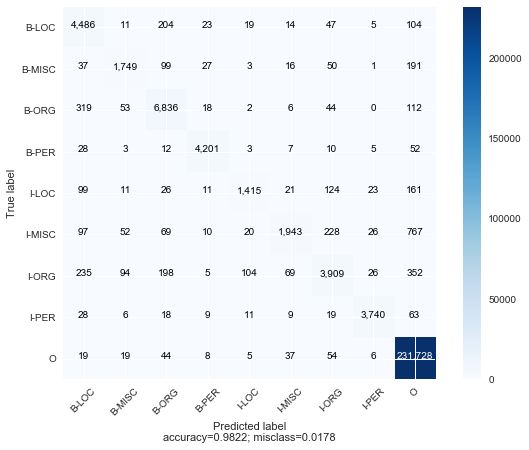

In [64]:
plot_confusion_matrix(cm=cm, normalize = False, target_names = labels, title = "")

### Understanding the results

Let's see what our model learned.
We'll start by comparing the first 10 named entities test lables, with the predicted lables:

In [65]:
print(y_test_pred[:10])
print(y_test_encoded[:10])

['B-LOC' 'I-LOC' 'O' 'O' 'O' 'O' 'B-ORG' 'O' 'O' 'O']
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O']


Tough this seems promissing, we did not check that the BIO tags produced by the tagger is a legal sequence. 
We will now identify sequences of BIO tags which are illegal and report on the frequency of this problem for each type of illegal tags transition (O-IX, IX-IY, BX-IY).

In [66]:
def add_to_dict(illigal_map, bio_first, bio_second):
    name = bio_first+'->'+bio_second
    if not name in illigal_map:
        illigal_map[name] = 1
    else:
        illigal_map[name] += 1

def checkIsValid(illigal_map, bio_first, bio_second):
    sep1 = bio_first.split('-')
    sep2 = bio_second.split('-')
    bad1 = (sep1[0] == 'O' and sep2[0] == 'I')
    bad2 = (sep1[0] == 'I' and sep2[0] == 'I' and sep1[1] != sep2[1])
    bad3 = (sep1[0] == 'B' and sep2[0] == 'I' and sep1[1] != sep2[1])
    if bad1 or bad2 or bad3:
        add_to_dict(illigal_map, bio_first, bio_second)


In [67]:
illigal_trans = {}
for ind in range(len(y_test_pred)-1):
    checkIsValid(illigal_trans, y_test_pred[ind], y_test_pred[ind+1])

The illigal sequences of BIO tags and there accurances:

In [68]:
import operator
sorted(illigal_trans.items(), key=operator.itemgetter(1), reverse=True)

[('O->I-ORG', 96),
 ('O->I-MISC', 49),
 ('I-MISC->I-ORG', 32),
 ('O->I-LOC', 25),
 ('B-PER->I-ORG', 25),
 ('I-ORG->I-MISC', 21),
 ('B-LOC->I-ORG', 21),
 ('B-MISC->I-ORG', 17),
 ('I-ORG->I-PER', 16),
 ('B-ORG->I-MISC', 15),
 ('I-LOC->I-ORG', 13),
 ('B-MISC->I-PER', 13),
 ('O->I-PER', 12),
 ('B-ORG->I-LOC', 12),
 ('B-LOC->I-MISC', 11),
 ('B-ORG->I-PER', 11),
 ('B-LOC->I-PER', 10),
 ('I-ORG->I-LOC', 10),
 ('I-MISC->I-LOC', 7),
 ('B-PER->I-MISC', 6),
 ('I-PER->I-ORG', 5),
 ('I-LOC->I-PER', 5),
 ('I-PER->I-MISC', 4),
 ('I-LOC->I-MISC', 3),
 ('I-MISC->I-PER', 3),
 ('B-PER->I-LOC', 1)]

In [69]:
print("There are a total of {} illigal transitions.".format(sum(illigal_trans.values())))

There are a total of 443 illigal transitions.


Since the DictVectorizer basically transforms the input into one-hot encoded vectors, then we loose the relashonship between similar words and words which should appear one after another. Changing this by using a word2vec model, might help us gain better results. <br>
Let's try this approach in the next section.

## Q3.2 Using Word Embeddings

We'll try to improve our greedy tagger for NER by using Word Embeddings as features. 

We'll first load a fixed amount of vectors from a pretrained spanish word2vec model.

In [113]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = '../data/wiki.es.vec'
amount = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit = amount)

Now we want to create a vectorized form of our features. We'll break this task into two parts.<br>
First we'll create the vectors as we did above, using the dictVectorizer. Only this time witout using the words in the sentence.<br>
This will reduce the amount of features in the vectorized dictionary drastically. <br>
(Since the values are strings, dictVec turns each string into a separate feature.)<br>
After we did that, we will use the word2vec model to transform the words in the sentences to dense vectors. For each word we'll use the previous and following words, along with the words themselves. This method will use padding.

In [72]:

def word2featuresNoWords(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'word.isupper^%s' % word.isupper(),
        'word.istitle^%s' % word.istitle(),
        'word.isdigit^%s' % word.isdigit(),
        'postag^' + postag,
        'postag[:2]^' + postag[:2],
    ]
    word1 = None
    postag1 = None
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
    else: # padding
        word1 = '&&'
        postag1 = 'BOS'
    features.extend([
        '-1:word.istitle^%s' % word1.istitle(),
        '-1:word.isupper^%s' % word1.isupper(),
        '-1:postag^' + postag1,
        '-1:postag[:2]^' + postag1[:2],
    ])
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
    else: # padding
        word1 = '@@'
        postag1 = 'EOS'
    features.extend([
        '+1:word.istitle^%s' % word1.istitle(),
        '+1:word.isupper^%s' % word1.isupper(),
        '+1:postag^' + postag1,
        '+1:postag[:2]^' + postag1[:2],
    ])
    return features


def sent2featuresNoWords(sent):
    return [word2featuresNoWords(sent, i) for i in range(len(sent))]  


In [73]:
X_train = [sent2featuresNoWords(s) for s in train_sents]
X_test = [sent2featuresNoWords(s) for s in test_sents]

In [74]:
final_x_train = []
for sentence_ind in range(int(len(X_train))):
    for word_ind in range(len(X_train[sentence_ind])):
        featuresToDict = dict(item.split("^") for item in X_train[sentence_ind][word_ind])
        final_x_train.append(featuresToDict)

In [75]:
final_x_test = []
for sentence_ind in range(len(X_test)):
    for word_ind in range(len(X_test[sentence_ind])):
        featuresToDict = dict(item.split("^") for item in X_test[sentence_ind][word_ind])
        final_x_test.append(featuresToDict)

In [76]:
vectorizer2 = DictVectorizer()
X_encoded = vectorizer2.fit_transform(final_x_train+final_x_test)
X_train_encoded1 = X_encoded[:len(final_x_train),:]
X_test_encoded1 = X_encoded[len(final_x_train):,:]

Now we'll create vectorized features using the gensin and the pretrained Spanish word2vec model.
Since we cant load all the vectorized words to our memory, we'll load a large amount of words (100K), and for words which do not have a vectorized representation we give a special key.

In [77]:
def word2featuresNew(sent, i):
    word = sent[i][0]
    if word.isdigit():
        word = 'N'
    postag = sent[i][1]
    features = [
        'word^' + word.lower(),
    ]
    word1 = None
    postag1 = None
    if i > 0:
        word1 = sent[i-1][0]
        if word1.isdigit():
            word1 = 'N'
        postag1 = sent[i-1][1]
    else: # padding
        word1 = 'BOS'
    features.extend([
        '-1:word^' + word1.lower(),
    ])
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        if word1.isdigit():
            word1 = 'N'
        postag1 = sent[i+1][1]
    else: # padding
        word1 = 'EOS'
    features.extend([
        '+1:word^' + word1.lower(),
    ])
    return features


def sent2featuresNew(sent):
    return [word2featuresNew(sent, i) for i in range(len(sent))]  


In [78]:
# we already have the lables, so only need the new features
X_train2 = [sent2featuresNew(s) for s in train_sents]
X_test2 = [sent2featuresNew(s) for s in test_sents]

In [84]:
def get_vectorized_features(featureDict):
    word_vectorized_features = []
    for feature in featureDict.values():
        if feature not in wordvectors:
            feature = 'oops'
        vectorized = list(wordvectors.word_vec(feature))
        word_vectorized_features += vectorized
    return word_vectorized_features

In [85]:
X_train_encoded2 = []
for sentence_ind in range(int(len(X_train2))):
    for word_ind in range(len(X_train2[sentence_ind])):
        featuresToDict = dict(item.split("^") for item in X_train2[sentence_ind][word_ind])
        word_vectorized_features = get_vectorized_features(featuresToDict)
        X_train_encoded2.append(word_vectorized_features)

In [86]:
X_test_encoded2 = []
for sentence_ind in range(len(X_test2)):
    for word_ind in range(len(X_test2[sentence_ind])):
        featuresToDict = dict(item.split("^") for item in X_test2[sentence_ind][word_ind])
        word_vectorized_features = get_vectorized_features(featuresToDict)
        X_test_encoded2.append(word_vectorized_features)

In [87]:
X_train_encoded = np.concatenate([X_train_encoded1.toarray(), X_train_encoded2], axis=1)
X_test_encoded = np.concatenate([X_test_encoded1.toarray(), X_test_encoded2], axis=1)

In [99]:
regs = {}
xtrain, xval, ytrain, yval = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2)
for reg in [0.5, 1., 2.]:
    classifier = LogisticRegression(multi_class='ovr', penalty='l2', C=reg, random_state=0)
    logistic_clsf = classifier.fit(xtrain,ytrain) 
    yval_pred = logistic_clsf.predict(xval)
    yv_pred = lb.transform(yval_pred)
    yv_real = lb.transform(yval)
    val_loss = mean_squared_error(yv_real, yv_pred)
    val_acc = accuracy_score(yv_real, yv_pred)
    regs[reg] = [val_loss, val_acc]

In [100]:
print(regs)

{0.5: [0.008159718943014184, 0.9632812647564362], 1.0: [0.008168113715589303, 0.9632434882798482], 2.0: [0.008184903260739538, 0.9631679353266721]}


Interestingly, for the model in which we encorporate the pre-trained word2vec model, there seems to be more of an overfitting, for which we need to add more regularization into our model.<br>
So we will use a C=0.5 regularizer (as opposed to C=2 we had before).

In [101]:
classifier_new = LogisticRegression(multi_class='ovr', penalty='l2', C=0.5, random_state=0)
logistic_clsf_new = classifier_new.fit(X_train_encoded,y_train_encoded) 

In [102]:
y_pred = logistic_clsf_new.predict(X_train_encoded)

In [103]:
yt_real = lb.transform(y_train_encoded)
yt_pred = lb.transform(y_pred)
print("The training loss is: {}".format(mean_squared_error(yt_real, yt_pred)))

The training loss is: 0.007213628073798445


In [104]:
y_test_pred = logistic_clsf_new.predict(X_test_encoded)
yt_real = lb.transform(y_test_encoded)
yt_pred = lb.transform(y_test_pred)
print("the test error is: {}".format(mean_squared_error(yt_real, yt_pred)))
print("the test accuracy is: {}".format(accuracy_score(yt_real, yt_pred)))

the test error is: 0.0085597793862401
the test accuracy is: 0.9614809927619196


In [105]:
tagset = set(lb.classes_) - {'O'}
tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}

In [106]:
print(classification_report(
        y_true = yt_real,
        y_pred = yt_pred,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    ))

             precision    recall  f1-score   support

      B-LOC       0.76      0.76      0.76      1084
      I-LOC       0.62      0.48      0.54       325
     B-MISC       0.53      0.45      0.49       339
     I-MISC       0.51      0.27      0.35       557
      B-ORG       0.78      0.82      0.80      1400
      I-ORG       0.73      0.55      0.62      1104
      B-PER       0.83      0.89      0.86       735
      I-PER       0.89      0.92      0.91       634

avg / total       0.74      0.69      0.71      6178



In [107]:
labels = classes
cm = confusion_matrix(y_train_encoded, y_pred, labels)
print(cm)

[[  4088     25    396    118     39     18     88     12    129]
 [    50   1234    281     65      8     45    108      4    378]
 [   453    122   6290    113      7     29     97      5    274]
 [    45     19     91   4015      6     10     26      8    101]
 [   192     21     53     42   1053     40    181    100    209]
 [   139    141    117     23     58   1216    430     57   1031]
 [   316    160    280     25    167    221   3188     76    559]
 [    29     12     29     37     30     13     44   3630     79]
 [    30     89    103     18     36     86    130     20 231408]]


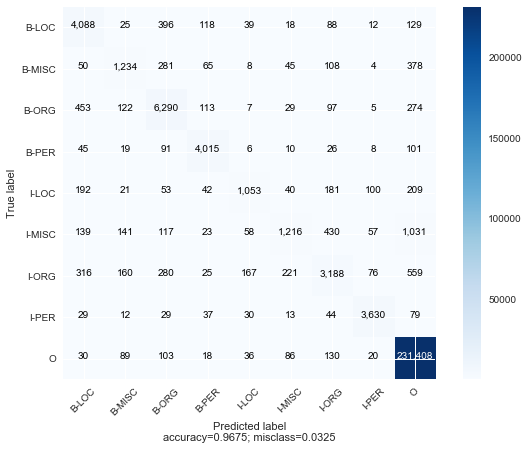

In [108]:
plot_confusion_matrix(cm=cm, normalize = False, target_names = labels, title = "")

In [109]:
print(y_test_pred[:10])
print(y_test_encoded[:10])

['B-LOC' 'I-LOC' 'O' 'O' 'O' 'O' 'B-ORG' 'O' 'O' 'O']
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O']


In [110]:
illigal_trans = {}
for ind in range(len(y_test_pred)-1):
    checkIsValid(illigal_trans, y_test_pred[ind], y_test_pred[ind+1])

In [111]:
import operator
sorted(illigal_trans.items(), key=operator.itemgetter(1), reverse=True)

[('O->I-ORG', 97),
 ('I-ORG->I-MISC', 50),
 ('I-MISC->I-ORG', 49),
 ('O->I-LOC', 38),
 ('O->I-MISC', 31),
 ('B-MISC->I-ORG', 21),
 ('B-ORG->I-MISC', 20),
 ('I-ORG->I-LOC', 17),
 ('I-LOC->I-ORG', 17),
 ('B-LOC->I-ORG', 15),
 ('B-ORG->I-LOC', 13),
 ('O->I-PER', 12),
 ('B-LOC->I-MISC', 11),
 ('I-ORG->I-PER', 11),
 ('B-ORG->I-PER', 10),
 ('I-LOC->I-PER', 8),
 ('I-PER->I-MISC', 8),
 ('B-LOC->I-PER', 6),
 ('B-MISC->I-LOC', 6),
 ('I-PER->I-ORG', 6),
 ('B-PER->I-LOC', 6),
 ('I-MISC->I-LOC', 5),
 ('I-LOC->I-MISC', 5),
 ('I-PER->I-LOC', 5),
 ('B-PER->I-ORG', 5),
 ('B-MISC->I-PER', 4),
 ('I-MISC->I-PER', 3),
 ('B-PER->I-MISC', 1)]

In [112]:
print("There are a total of {} illigal transitions.".format(sum(illigal_trans.values())))

There are a total of 480 illigal transitions.


So when comparing the hybrid model (based on word2vec + one-hot encoded vectors) with the model which only uses the one-hot vectors:<br>
Although we were able to gain a bit better accuracy and recall for the dictVectorizer from the previous section. The F-score in both is the same.<br>
Another thing to notice is that the hybrid model had even more illigal transitions.<br>
A possible explanation for this might be that the word2vec based model has the ability to learn word similarities, and therefor gives tags to similar words which might cause an illigal transition. Another possibility is that the hybrid model gives too much importance to the word vectors, which take up a big amount of space. But this is only a hypothesis.   